<a href="https://colab.research.google.com/github/Yakuy/Gemastik13/blob/master/Resnet_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#train network
import os
import datetime
import json
import glob
import torch.backends.cudnn as cudnn
import torch
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from tqdm import tqdm
#load data
from torch.utils.data import Dataset
import random
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
from torchvision import transforms, datasets, models

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEaq-5CTTSnGZnyezBhBeLa6Y70FdZCdqD1M6bWZioiL5-U9WvlA6g
Mounted at /content/drive


In [ ]:
#buat load data
class ChestXrayDataSetTest(Dataset):
    def __init__(self, image_list_file, transform=None, combine_pneumonia=False):
        """
        Create the Data Loader.
        Since class 3 (Covid) has limited data, dataset size will be accordingly at train time.
        Code is written in generic form to assume last class as the rare class

        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
            combine_pneumonia: True for combining Baterial and Viral Pneumonias into one class
        """
        self.NUM_CLASSES = 3 if combine_pneumonia else 4
        # Set of images for each class
        image_names = []

        with open(image_list_file, "r") as f:
            for line in f:
                items = line.split()
                image_name = items[0]+' '+items[1]
                label = int(items[2])
                image_names.append((image_name, label))

        self.image_names = image_names
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """
        def __one_hot_encode(l):
            v = [0] * self.NUM_CLASSES
            v[l] = 1
            return v

        image_name, label = self.image_names[index]
        #label = __one_hot_encode(label)
        #print(label)
        image = Image.open(image_name).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_names)


class ChestXrayDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, combine_pneumonia=False):
        """
        Create the Data Loader.
        Since class 3 (Covid) has limited data, dataset size will be accordingly at train time.
        Code is written in generic form to assume last class as the rare class

        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
            combine_pneumonia: True for combining Baterial and Viral Pneumonias into one class
        """
        self.NUM_CLASSES = 3 if combine_pneumonia else 4
        
        # Set of images for each class
        image_names = [[] for _ in range(self.NUM_CLASSES)]

        with open(image_list_file, "r") as f:
            for line in f:
                items = line.split()
                image_name = items[0]+ ' ' + items[1]
                label = int(items[2])
                image_names[label].append(image_name)
        #print(image_list_file)
        #print(image_names)

        self.image_names = image_names
        self.transform = transform
        label_dist = [len(cnames) for cnames in image_names]

        # Number of images of each class desired
        self.num_covid = int(label_dist[-1])
        if combine_pneumonia:
            covid_factor = 7.0
            self.num_normal = int(self.num_covid * covid_factor)
            self.num_pneumonia = int(self.num_covid * covid_factor)
            self.total = self.num_covid + self.num_pneumonia + self.num_normal
            self.loss_weight_minus = torch.FloatTensor([self.num_normal, self.num_pneumonia, self.num_covid]).unsqueeze(0).cuda() / self.total
            self.loss_weight_plus = 1.0 - self.loss_weight_minus
        else:
            covid_factor = 5.0
            self.num_normal = int(self.num_covid * covid_factor)
            self.num_viral = int(self.num_covid * covid_factor)
            self.num_bact = int(self.num_covid * covid_factor)
            self.total = self.num_covid + self.num_viral + self.num_bact + self.num_normal
            self.loss_weight_minus = torch.FloatTensor([self.num_normal, self.num_bact, self.num_viral, self.num_covid]).unsqueeze(0).cuda() / self.total
            self.loss_weight_plus = 1.0 - self.loss_weight_minus

        # print (self.loss_weight_plus, self.loss_weight_minus)

        if combine_pneumonia:
            self.partitions = [self.num_covid,
                                self.num_covid + self.num_normal,
                                self.num_covid + self.num_normal + self.num_pneumonia]
        else:
            self.partitions = [self.num_covid,
                                self.num_covid + self.num_normal,
                                self.num_covid + self.num_normal + self.num_bact,
                                self.num_covid + self.num_normal + self.num_bact + self.num_viral]

        assert len(self.partitions) == self.NUM_CLASSES

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """

        def __one_hot_encode(l):
            v = [0] * self.NUM_CLASSES
            v[l] = 1
            return v

        image_name = None
        # print (index, self.partitions, len(self), sum([len(cnames) for cnames in self.image_names]))
        if index < self.partitions[0]:
            # Return a covid image
            data_idx = index
            image_name = self.image_names[self.NUM_CLASSES - 1][data_idx]
            #print(self.NUM_CLASSES - 1)
            label = self.NUM_CLASSES - 1
        else:
            # Return non-covid image
            for l in range(1, self.NUM_CLASSES):
                if index < self.partitions[l]:
                    class_idx = l - 1
                    #print(class_idx)
                    label = class_idx
                    # Return a random image
                    image_name = random.choice(self.image_names[class_idx])
                    break
        assert image_name is not None
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.partitions[-1]

    def loss(self, output, target):
        """
        Binary weighted cross-entropy loss for each class
        """
        weight_plus = torch.autograd.Variable(self.loss_weight_plus.repeat(1, target.size(0)).view(-1, self.loss_weight_plus.size(1)).cuda())
        weight_neg = torch.autograd.Variable(self.loss_weight_minus.repeat(1, target.size(0)).view(-1, self.loss_weight_minus.size(1)).cuda())

        loss = output
        pmask = (target >= 0.5).data
        nmask = (target < 0.5).data
        
        epsilon = 1e-15
        loss[pmask] = (loss[pmask] + epsilon).log() * weight_plus[pmask]
        loss[nmask] = (1-loss[nmask] + epsilon).log() * weight_plus[nmask]
        loss = -loss.sum()
        return loss

In [ ]:
def load_covid_dataset(TEST_IMAGE_LIST, TRAIN_IMAGE_LIST, VAL_IMAGE_LIST, batch_size=64, combine_pneumonia=True):
    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    train_loader  = torch.utils.data.DataLoader(ChestXrayDataSet(image_list_file=TRAIN_IMAGE_LIST,
                                        transform=transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()]),
                                        combine_pneumonia=True), batch_size=batch_size, shuffle=True)
    
    test_loader   = torch.utils.data.DataLoader(ChestXrayDataSetTest(image_list_file=TEST_IMAGE_LIST,
                                        transform=transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()]),
                                        combine_pneumonia=True), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(ChestXrayDataSetTest(image_list_file=VAL_IMAGE_LIST,
                                        transform=transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()]),
                                        combine_pneumonia=True), batch_size=batch_size, shuffle=True)
    return train_loader, test_loader, val_loader

In [ ]:
TRAIN_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/strat_train.txt'
VAL_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/strat_val.txt'
TEST_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/strat_test.txt'
TEST_DIR = '/content/drive/My Drive/CovidAID/data/samples'

In [ ]:
trainloader, testloader, valloader = load_covid_dataset(TEST_IMAGE_LIST, TRAIN_IMAGE_LIST, VAL_IMAGE_LIST)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3),
                                 nn.LogSoftmax(dim=0))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def test(model, test_loader):
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
                    
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    return test_loss, accuracy

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(20,10))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

In [ ]:
save_loc = '/content/drive/My Drive/Deep Learning/Gemastik13/Experimental/Models/'
def train(epochs, model, trainloader, valloader, log_file='log_resnet.csv'):
    print("Preparing.....")
    import csv
    from time import time
    epochs = epochs
    train_losses, test_losses = [], []
    logfile = open(save_loc + log_file, "w")
    logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'loss', 'val_loss', 'val_acc'])
    logwriter.writeheader()
    print("Begin training......")
    for epoch in range(epochs):
        start = time()
        epoch_now = epoch + 1
        for i, (inputs, labels) in enumerate(trainloader):
            running_loss = 0
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # test the mdoel    
        test_loss, accuracy = test(model, valloader)

        # important variable
        w_train_loss = round(running_loss/len(trainloader), 3)
        w_test_loss = round(test_loss/len(valloader), 3)
        w_test_accuracy = round(accuracy/len(valloader), 3)

        # write everything
        train_losses.append(w_train_loss)
        test_losses.append(w_test_loss)
        logwriter.writerow(dict(epoch=epoch_now, loss=w_train_loss,
                                val_loss=w_test_loss, val_acc=w_test_accuracy))
        print(f"Epoch {epoch_now}/{epochs}.. "
              f"Train loss: {w_train_loss}.. "
              f"Test loss: {w_test_loss}.. "
              f"Test accuracy: {w_test_accuracy}.. "
              f"Time: {time() - start}")
        model.train()

    logfile.close()
    plot_loss(train_losses, test_losses)

Preparing.....
Begin training......
Epoch 1/50.. Train loss: 0.053.. Test loss: 3.895.. Test accuracy: 0.626.. Time: 138.88840532302856
Epoch 2/50.. Train loss: 0.054.. Test loss: 3.856.. Test accuracy: 0.752.. Time: 137.22241854667664
Epoch 3/50.. Train loss: 0.052.. Test loss: 3.795.. Test accuracy: 0.789.. Time: 136.6043028831482
Epoch 4/50.. Train loss: 0.054.. Test loss: 3.789.. Test accuracy: 0.733.. Time: 136.417551279068
Epoch 5/50.. Train loss: 0.053.. Test loss: 3.73.. Test accuracy: 0.814.. Time: 135.4450957775116
Epoch 6/50.. Train loss: 0.053.. Test loss: 3.773.. Test accuracy: 0.784.. Time: 135.74752068519592
Epoch 7/50.. Train loss: 0.055.. Test loss: 3.773.. Test accuracy: 0.762.. Time: 134.98543572425842
Epoch 8/50.. Train loss: 0.052.. Test loss: 3.728.. Test accuracy: 0.784.. Time: 135.82768869400024
Epoch 9/50.. Train loss: 0.053.. Test loss: 3.742.. Test accuracy: 0.792.. Time: 137.0458061695099
Epoch 10/50.. Train loss: 0.052.. Test loss: 3.727.. Test accuracy: 0.

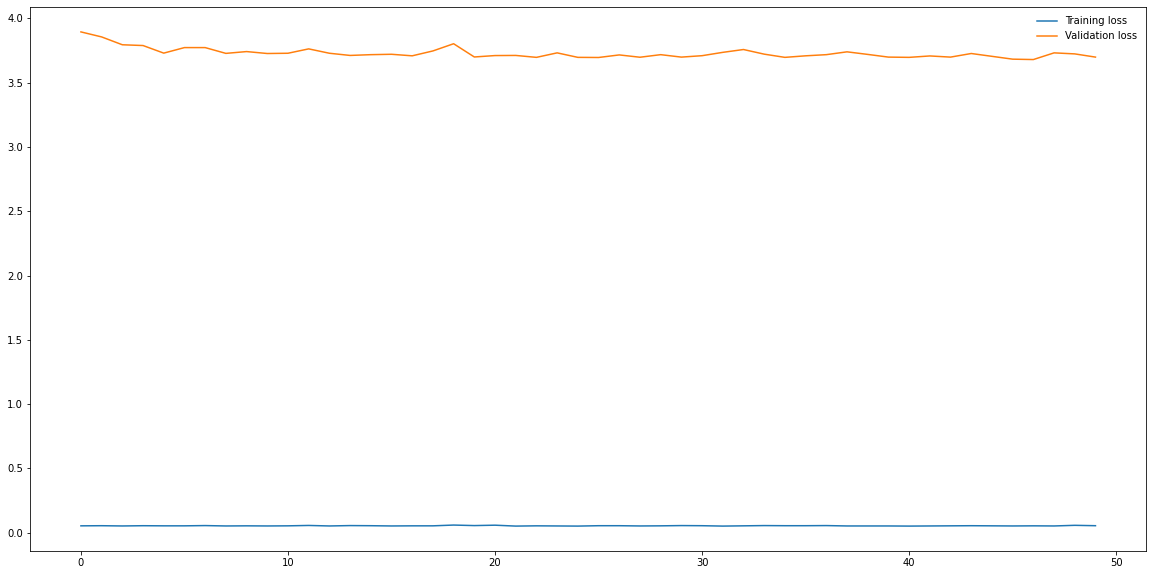

In [ ]:
train(50, model, trainloader, valloader)

In [ ]:
# plt.figure(figsize=(20,10))
# plt.plot(train_losses, label='Training loss')
# plt.plot(test_losses, label='Validation loss')
# plt.legend(frameon=False)
# plt.show()

In [ ]:
torch.save(model.state_dict(), save_loc + "RestNet_covid.pkl")

In [ ]:
log_resnet = pd.read_csv(save_loc + 'log_resnet.csv')
log_resnet.head()

,epoch,loss,val_loss,val_acc
0,1,0.053,3.895,0.626
1,2,0.054,3.856,0.752
2,3,0.052,3.795,0.789
3,4,0.054,3.789,0.733
4,5,0.053,3.730,0.814


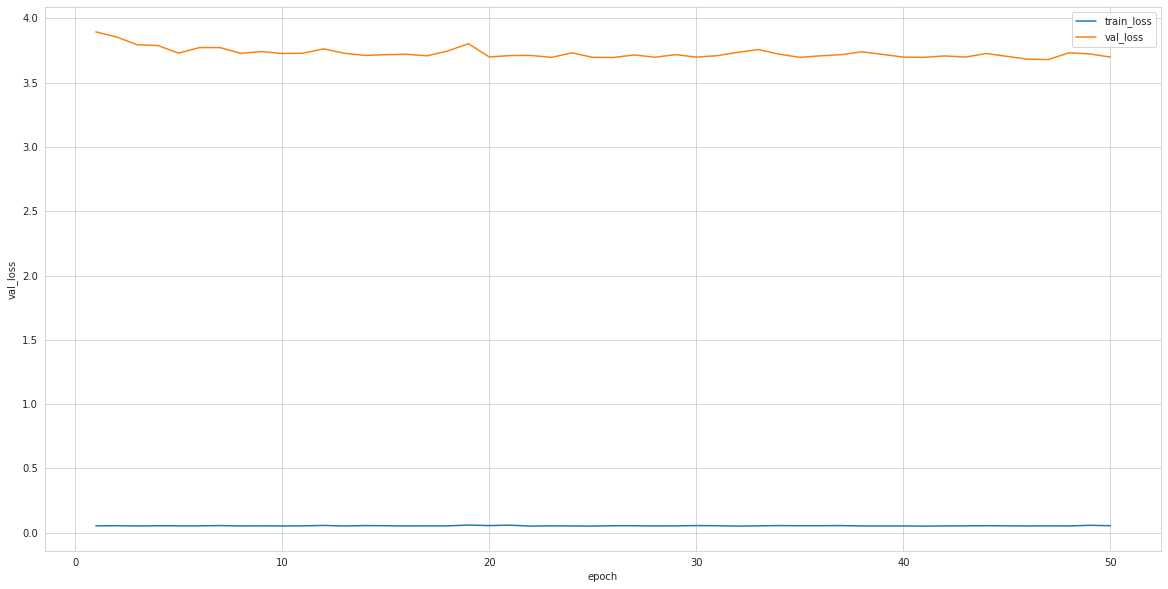

In [ ]:
plt.figure(figsize=(20,10))
sn.set_style("whitegrid")
sn.lineplot(x = 'epoch', y = 'loss', data = log_resnet)
sn.lineplot(x = 'epoch', y = 'val_loss', data = log_resnet)
plt.legend(labels=['train_loss', 'val_loss'])

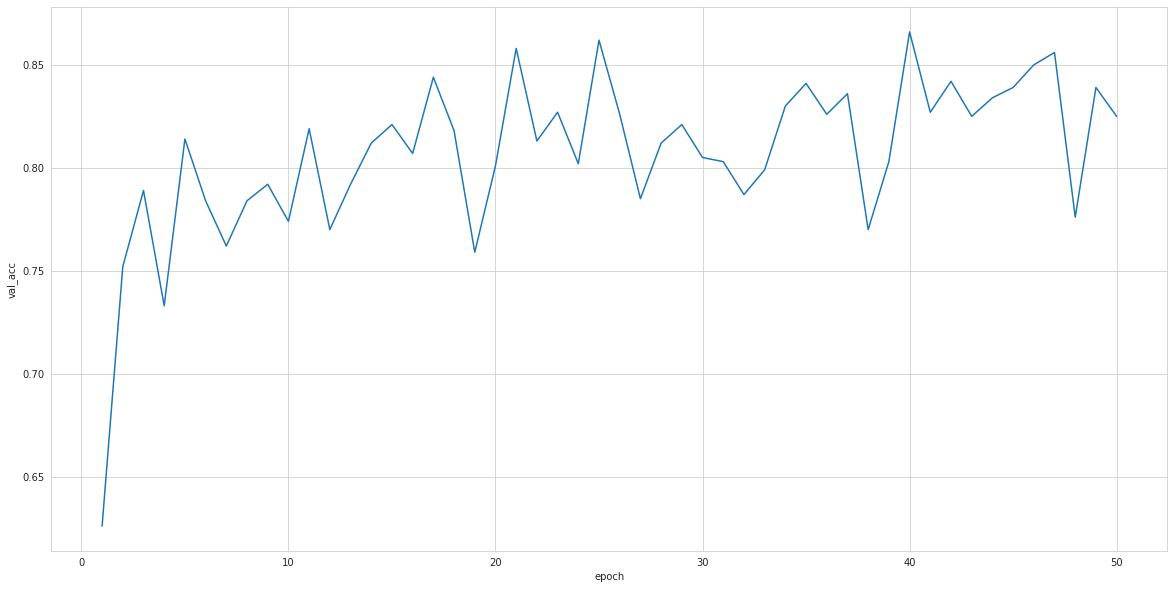

In [ ]:
plt.figure(figsize=(20,10))
sn.lineplot(x = 'epoch', y = 'val_acc', data=log_resnet)

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/CovidAID/experimental/save_dir/RestNet_covid.pkl"))

<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0
Y_pred = []
Y_true = []
for x, y in testloader:
    y = torch.zeros(y.size(0), 3).scatter_(1, y.view(-1, 1), 1)
    x, y = Variable(x.cuda(), volatile=True), Variable(y.cuda())
    y_pred = model(x)
    y_pred = y_pred.data.max(1)[1]
    y_true = y.data.max(1)[1]
    Y_pred.append(y_pred)
    Y_true.append(y_true)
Y_TRUE = np.array([])
Y_PRED = np.array([])
for tensor in Y_true:
  Y_TRUE = np.concatenate((Y_TRUE, tensor.cpu().numpy()), axis=0)

for tensor in Y_pred:
  Y_PRED = np.concatenate((Y_PRED, tensor.cpu().numpy()), axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


In [ ]:
cm = confusion_matrix(Y_TRUE, Y_PRED)
cl = classification_report(Y_TRUE, Y_PRED)

In [ ]:
print(cm)
print(cl)

[[307   6   4]
 [161 663  30]
 [  9   0  82]]
              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77       317
         1.0       0.99      0.78      0.87       854
         2.0       0.71      0.90      0.79        91

    accuracy                           0.83      1262
   macro avg       0.78      0.88      0.81      1262
weighted avg       0.88      0.83      0.84      1262

